In [1]:
import spacy
import numpy as np
import pandas as pd
import csv 
import sys
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes()


/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Model Selection

In [2]:
# Reading both original datasets (<Artist, Song, Emotion>)
moodyLyrics4QDF = pd.read_csv('./datasets/MoodyLyrics4Q.csv')
moodyLyricsDF   = pd.read_csv('./datasets/moodylyrics_cleaned.csv')
# and featurized ones (<Lyrics + features>)
moodyLyrics4QFeat = pd.read_csv('./datasets/moodylyrics4q_featurized.csv')
moodyLyricsFeat = pd.read_csv('./datasets/moodylyrics_featurized.csv')

In [3]:
selected_columns = [
   'LYRICS_VECTOR',
   #'WORD_COUNT', 
   'ECHOISMS',
   #'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 
   'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY',
   'EMOTION'
]
# Reduced dataset
r_moodyLyrics4QFeat = moodyLyrics4QFeat[selected_columns]
r_moodyLyricsFeat = moodyLyricsFeat[selected_columns]

In [22]:
# Function to get X and y of the correct shape 
# X = (..., 310)
# y = (...,)
def get_X_y(dataset, emotion=True):
    if emotion is True:
        tmp_df = dataset.drop(['EMOTION'], axis=1)
    else:
        tmp_df = dataset
    X = list()
    for (i, row) in tmp_df.iterrows():
        sub_list = list()
        for field in row:
            if type(field) == str:
                field = field[1:-1].split()
                sub_list += [float(x.replace('\n','')) for x in field]
            else:
                sub_list.append(field)
        X.append(np.array(sub_list))
    X = np.array(X)
    if emotion is True:
        y = dataset['EMOTION'].as_matrix().T
        return X, y
    else:
        return X

# Get X and y for Neural Network
# X_nn = (..., 310) but scaled
# y_nn = (..., 4)
def get_Xnn_ynn(X, y):
    encoder = LabelEncoder()
    encoded_y = encoder.fit_transform(y)
    print(encoder.inverse_transform([0, 1, 2, 3]))
    y_nn = np_utils.to_categorical(encoded_y)

    sc = StandardScaler()
    X_nn = sc.fit_transform(X)
    return X_nn, y_nn

## The model

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
    
def build_ann(optimizer='adam', input_size=310):
    classifier = Sequential()
    
    # Add input layer
    classifier = Sequential()
    # Add input layer
    classifier.add(Dense(units = 175, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.1))  
    # Add hidden layers
    classifier.add(Dense(units = 175, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    classifier.add(Dropout(0.1))             
    #classifier.add(Dense(units = 150, kernel_initializer = 'random_normal', activation = 'sigmoid'))
    #classifier.add(Dropout(0.5))  
    # Add output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))
    
    # Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

## First Attempt: TRAIN:moodyLyrics TEST:moodyLyrics4Q

In [23]:
'''
Here we try to use moodyLyricsFeat as training set
and moodyLyrics4QFeat as test set 
'''
X_train, y_train = get_X_y(r_moodyLyricsFeat)
X_train_nn, y_train_nn = get_Xnn_ynn(X_train, y_train)

X_test, y_test = get_X_y(r_moodyLyrics4QFeat)
X_test_nn, y_test_nn = get_Xnn_ynn(X_test,y_test)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 128, epochs = 50, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

filename = './models/train_ml_test_ml4q.h5'
classifier.save(filename)
print('Classifier saved to', filename)

/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['angry' 'happy' 'relaxed' 'sad']


/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['angry' 'happy' 'relaxed' 'sad']
Accuracy: 40.36
Classifier saved to ./models/train_ml_test_ml4q.h5


## Second Attempt: TRAIN: moodyLyrics4Q, TEST: moodyLyrics

In [24]:
'''
Here we try to use moodyLyrics4QFeat as training set
and moodyLyricsFeat as test set 
'''
X_train, y_train = get_X_y(r_moodyLyrics4QFeat)
X_train_nn, y_train_nn = get_Xnn_ynn(X_train, y_train)

X_test, y_test = get_X_y(r_moodyLyricsFeat)
X_test_nn, y_test_nn = get_Xnn_ynn(X_test,y_test)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 128, epochs = 50, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

filename = './models/train_ml4q_test_ml.h5'
classifier.save(filename)
print('Classifier saved to', filename)

/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['angry' 'happy' 'relaxed' 'sad']


/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['angry' 'happy' 'relaxed' 'sad']
Accuracy: 47.81
Classifier saved to ./models/train_ml4q_test_ml.h5


## Third Attempt: MoodyLyrics Alone

In [25]:
'''
Here we try to use moodyLyricsFeat alone, both for training and for test
'''
X, y = get_X_y(r_moodyLyricsFeat)
X_nn, y_nn = get_Xnn_ynn(X, y)

X_train_nn, X_test_nn,  y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size = 0.2)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 128, epochs = 50, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))
filename = './models/ml_alone.h5'
classifier.save(filename)
print('Classifier saved to', filename)

/Users/saragiammusso/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['angry' 'happy' 'relaxed' 'sad']
Accuracy: 86.75
Classifier saved to ./models/ml_alone.h5


## Fourth attempt: MoodyLyrics4Q alone

In [114]:
'''
Here we try to use moodyLyrics4QFeat alone, both for training and for test
'''
X, y = get_X_y(r_moodyLyrics4QFeat)
X_nn, y_nn = get_Xnn_ynn(X, y)

X_train_nn, X_test_nn,  y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size = 0.2)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 512, epochs = 100, 
               validation_split=0.3, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

filename = './models/ml4q_alone.h5'
classifier.save(filename)
print('Classifier saved to', filename)

Accuracy: 56.07
Classifier saved to ./models/ml4q_alone.h5


## Fifth Attempt: Together

In [115]:
'''
Here we try to use moodyLyricsFeat + moodyLyrics4QFeat together
'''

joint_dataset = pd.concat([r_moodyLyricsFeat , r_moodyLyrics4QFeat])
X, y = get_X_y(joint_dataset)
X_nn, y_nn = get_Xnn_ynn(X, y)

X_train_nn, X_test_nn,  y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size = 0.2)

#labels = encoder.inverse_transform([0, 1, 2, 3])
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 128, epochs = 50, 
               validation_split=0.1, verbose=False)

y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

y_true = np.argmax(y_test_nn,axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

filename = './models/ml_ml4q.h5'
classifier.save(filename)
print('Classifier saved to', filename)

Accuracy: 68.93
Classifier saved to ./models/ml_ml4q.h5


# Playlist Test File

In [10]:
emotion_labels = {'^rage!': 'angry', 'crying$': 'sad', 'party!': 'happy', 'sleeping':'relaxed'}
path = './datasets/silver_standard/'

playlist_test = list()
songs = list()

for dir in os.listdir(path):
    if dir in emotion_labels:
        for filename in os.listdir(os.path.join(path,dir)):
            # Create a list with <Playlist_PID, Playlist_Emotion>
            ppid = filename.split('.')[0]
            pemotion = emotion_labels[dir]
            playlist_test.append((ppid, pemotion))
            # Create a list with <Playlist_PID, TrackName, ArtistName>
            f = open(os.path.join(path, dir+'/'+filename), 'r')
            reader = csv.reader(f)
            headers = next(reader, None)
            for row in reader:
                songs.append((ppid, row[2], row[4]))

playlist_testDF = pd.DataFrame(playlist_test, columns=['PID','Emotion'])
songs_testDF = pd.DataFrame(songs, columns=['Pid','Title','Artist'])          

playlist_testDF.to_csv(os.path.join(path, 'playlist_test.csv'))
songs_testDF.to_csv(os.path.join(path, 'songs_test.csv'))

In [11]:
playlist_testDF.head(5)

,PID,Emotion
0,130767,angry
1,176336,angry
2,213226,angry
3,2466,angry
4,317182,angry


In [12]:
songs_testDF.head(5)

,Pid,Title,Artist
0,130767,This Girl (Kungs Vs. Cookin' On 3 Burners) - K...,Kungs
1,130767,Cocaine Model,ZHU
2,130767,Middle,DJ Snake
3,130767,This Is What You Came For,Calvin Harris
4,130767,Clarity,Zedd


# Classify Playlist

## Generate featurized song DF

### Download lyrics

In [109]:
import lyricwikia 
path = './datasets/silver_standard/lyrics'
count = 0
errors = 0
total = len(songs_testDF)
for idx, row in songs_testDF.iterrows():
    try: 
        lyric = lyricwikia.get_lyrics(row['Artist'], row['Title'])
        filename = row['PID'] + '_' + row['Artist'] + '_' + row['Title'] + '.txt'
        filename = filename.replace("/", " ")
        with open(os.path.join(path, filename), 'w') as sfile:
            sfile.write(lyric)
        count += 1
        sys.stdout.write("\r" + str(count) + '/' + str(total))
        sys.stdout.flush()
    except lyricwikia.LyricsNotFound:
        errors += 1
        #print('Could not download', row['Artist'], row['Title'])
        
print(errors, 'errors over', len(songs_testDF))

1538/2081543 errors over 2081


## Song Classification

In [13]:
'''
First we have to create a new dataset with the songs for which
we succeed in downloading the lyrics
'''
path = './datasets/silver_standard/lyrics'
songs = list()
for song in os.listdir(path):
    row = song.split('_')
    if len(row) == 3:
        pid, artist, title = row
        title = title.split('.')[0]
        songs.append((pid,title,artist))

songsDF = pd.DataFrame(data = songs, columns = ['PID','Title','Artist'])
print('Total songs in the dataset', len(songsDF),'instead of', len(songs_testDF))

Total songs in the dataset 1536 instead of 2081


In [15]:
songsDF.to_csv('./datasets/silver_standard/songsDF.csv')

There were 40 playlists.
Now, there are 38 playlists.


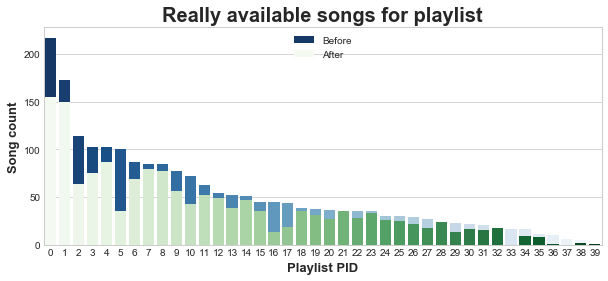

In [223]:
'''
Since we know that we weren't able to download all the lyrics
we want to see how this has impacted our playlists 
'''

before = songs_testDF['Pid'].value_counts().sort_index()
after = songsDF['PID'].value_counts().sort_index()
df = pd.concat([before, after], axis=1)
df.columns = ['Before','After']
df = df.sort_values(by = 'Before', ascending=False)

print('There were', len(before), 'playlists.')
print('Now, there are',len(after),'playlists.')
plt.figure(figsize=(10,4 ))
plt.title('Really available songs for playlist',fontsize=20, fontweight='bold')
ax = sns.barplot(x=np.array(range(len(df))),y=df['Before'], palette='Blues_r', label='Before')
ax = sns.barplot(x=np.array(range(len(df))),y=df['After'], ax=ax, palette='Greens', label='After')
plt.legend()
b = ax.set_xlabel('Playlist PID',fontsize=13, fontweight='bold')
b = ax.set_ylabel('Song count',fontsize=13, fontweight='bold')

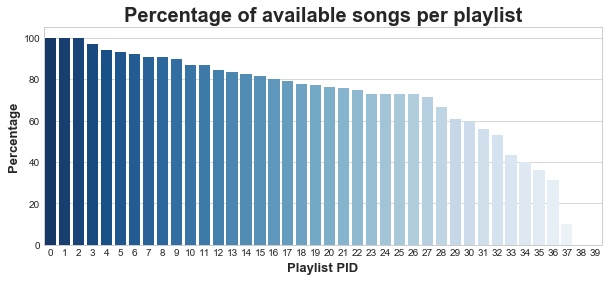

In [226]:
percentage = df['After']/df['Before'] * 100
percentage = percentage.sort_values(ascending=False)
plt.figure(figsize=(10,4 ))
plt.title('Percentage of available songs per playlist',fontsize=20, fontweight='bold')
ax = sns.barplot(x=np.array(range(len(before))),y=percentage, palette='Blues_r')
b = ax.set_xlabel('Playlist PID',fontsize=13, fontweight='bold')
b = ax.set_ylabel('Percentage',fontsize=13, fontweight='bold')


In [18]:
'''
Now we want to featurize our song dataset

FIRST: we load the spaCy model

'''
import spacy
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa
import io

nlp = spacy.load('en_core_web_lg')
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
path = './datasets/silver_standard/lyrics'
count = 0


In [20]:
'''
SECOND: we featurize the dataset 
'''
rows = list() 
for idx, row in songsDF.iterrows():
    fname = row['PID'] + '_' + row['Artist'] + '_' + row['Title'] + '.txt'
    fname = os.path.join(path, fname)
    if os.path.lexists(fname):
        with io.open(fname, 'r', encoding='utf-8', errors='replace') as f:
            content = f.read()
            lyric_doc = nlp(content)
            title_doc = nlp(row['Title'])

            lyric = preprocess(content)#lyric_doc.text)
            features = feature_extraction(lyric, row['Title'])

            freq = features['frequencies'] 

            sentiment = sa.analyse(content)

            elem = (
              row['PID'],
              row['Artist'], row['Title'],
              lyric_doc.vector, title_doc.vector,
              features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
              #get_slang_counts(lyric),
              features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
              count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
              features['rhymes'],#get_rhymes(lyric),
              features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
              freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
              freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
              freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
              freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
              # Sentiment analysis stuff
              sentiment[0], sentiment[1]
            )

            rows.append(elem)
            count += 1
            sys.stdout.write("\r" + str(count) + '/' + str(len(songsDF)))
            sys.stdout.flush()
            
            
songsFeat = pd.DataFrame(rows)
songsFeat.columns = ['PLAYLIST_PID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR', 'TITLE_VECTOR', 
        'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
        'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
        'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
        'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
        'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
        'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
        'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
        'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
        'SENTIMENT', 'SUBJECTIVITY'
  ]

1461/1536

For some reason we only featurized 1461 songs instead of 1536

In [21]:
songsFeat.to_csv('./datasets/silver_standard/songs_featurized2.csv')
print(songsFeat.shape)

(1461, 36)


In [28]:
'''
Now we can finally classify songs 

'''
songsFeat = pd.read_csv('./datasets/silver_standard/songs_featurized2.csv')
path = './models'
selected_columns = [
   'PLAYLIST_PID',
   'LYRICS_VECTOR',
   #'WORD_COUNT', 
   'ECHOISMS',
   #'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 
   'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY'
]
r_songsFeat = songsFeat[selected_columns]
X = get_X_y(r_songsFeat.drop('PLAYLIST_PID',axis=1), emotion=False)
sc = StandardScaler()
X_nn = sc.fit_transform(X)
'''
At the end we just have 3 models:
    - MoodyLyrics alone
    - MoodyLyrics4Q alone
    - both together
'''
n_models = 3

predictions = np.ones((n_models, len(X), 4))
models = ['ml_alone.h5','ml4q_alone.h5', 'ml_ml4q.h5']
i = 0

for filename in models:
    model = load_model(os.path.join(path,filename))
    y_pred = model.predict(X_nn)
    predictions[i,:,:] = y_pred
    i += 1

In [36]:
'''
Now we want to append the Emotion columns (4), to SongFeat
considering the 3 different models. 
Let's start with the first --- ml_alone.h5
'''

predictionsDF = pd.DataFrame(data = predictions[0], columns = ['angry', 'happy','relaxed' ,'sad'])
songsFeat_ml_alone = pd.concat([songsFeat, predictionsDF], axis=1)

'''
Now the second --- ml4q_alone.h5
'''
predictionsDF = pd.DataFrame(data = predictions[1], columns = ['angry', 'happy','relaxed' ,'sad'])
songsFeat_ml4q_alone = pd.concat([songsFeat, predictionsDF], axis=1)


'''
And the third --- ml_ml4q.h5
'''
predictionsDF = pd.DataFrame(data = predictions[2], columns = ['angry', 'happy','relaxed' ,'sad'])
songsFeat_ml_ml4q = pd.concat([songsFeat, predictionsDF], axis=1)


## Playlist Classification

Now we are ready to classify playlists.<br>
First step: we want to create a dataframe with 'Playlist_pid, playlist_emotion_vector', where 'emotion_vector' is the mean of the emotion vectors of the songs in that playlist.

In [93]:
'''
FIRST:
For each model we want to create a dataframe with 
        < Playlist_PID, emotion_vector > 
where <emotion_vector> is the "mean" of the emotion vectors of the songs in that playlist
'''
emotion_labels = ['angry', 'happy','relaxed' ,'sad']
map_mean = dict()
for emotion in emotion_labels:
    map_mean[emotion] = 'mean'
    
playlistDf_ml_alone = songsFeat_ml_alone.groupby(by='PLAYLIST_PID',as_index=False).agg(map_mean)
playlistDf_ml4q_alone = songsFeat_ml4q_alone.groupby(by='PLAYLIST_PID',as_index=False).agg(map_mean)
playlistDf_ml_ml4q = songsFeat_ml_ml4q.groupby(by='PLAYLIST_PID',as_index=False).agg(map_mean)

'''
SECOND:
we join the previous dataframes with the real predictions

'''

playlist_testDF.PID = playlist_testDF.PID.astype(int)
predictions_ml_alone = pd.merge(playlistDf_ml_alone, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 
predictions_ml4q_alone = pd.merge(playlistDf_ml4q_alone, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID'])
predictions_ml_ml4q = pd.merge(playlistDf_ml_ml4q, playlist_testDF,left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 

predictions_ml_alone.head(10)

,PLAYLIST_PID,angry,happy,relaxed,sad,PID,Emotion
0,2100,0.274648,0.253071,0.266036,0.206246,2100,happy
1,2466,0.675195,0.102375,0.035419,0.187011,2466,angry
2,2575,0.000026,0.065398,0.934437,0.000138,2575,happy
3,3529,0.206754,0.242471,0.470642,0.080132,3529,relaxed
4,3553,0.311585,0.189980,0.262325,0.236111,3553,happy
5,6721,0.079163,0.510674,0.257736,0.152427,6721,relaxed
6,8570,0.447677,0.128973,0.186982,0.236368,8570,happy
7,8658,0.154163,0.404654,0.291073,0.150110,8658,happy
8,9655,0.062331,0.226563,0.197215,0.513890,9655,happy
9,10224,0.313787,0.146255,0.246128,0.293831,10224,happy


In [111]:
'''
Now let's see the accuracies...
'''
y_true_labels = [x[6] for x in predictions_ml_alone.values]
encoder = LabelEncoder()
y_true = encoder.fit_transform(y_true_labels)
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_alone.values]), axis=1)
print('Accuracies...')
print('First model: MoodyLyrics alone', round(accuracy_score(y_true, y_pred),2))

'''
SECOND MODEL: MoodyLyrics4q alone
'''
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml4q_alone.values]), axis=1)
print('Second model: MoodyLyrics4Q alone', round(accuracy_score(y_true, y_pred),2))

'''
THIRD MODEL: MoodyLyrics + MoodyLyrics4Q
'''
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_ml4q.values]), axis=1)
print('Third model: ML + ML4Q', round(accuracy_score(y_true, y_pred),2))

Accuracies...
First model: MoodyLyrics alone 0.34
Second model: MoodyLyrics4Q alone 0.55
Third model: ML + ML4Q 0.47


In [108]:
def custom_accuracy(y_true, y_pred):
    count = 0
    for i in range(len(y_pred)):
        if y_true[i] == 1:
            jolly = 2
        elif y_true[i] == 2:
            jolly = 1
        elif y_true[i] == 0:
            jolly = 3
        elif y_true[i] == 3:
            jolly = 0

        if y_true[i] == y_pred[i] or y_pred[i] == jolly:
            count += 1
            
    return count/len(y_pred)

In [112]:
'''
We want to compute the accuracy in a particular way, i.e., in the predictions we
consider a right answer the couple ('Happy','Relaxed') (1,2) and the couple ('Angry','Sad') (0,3)

'''
y_true_labels = [x[6] for x in predictions_ml_alone.values]
encoder = LabelEncoder()
y_true = encoder.fit_transform(y_true_labels)

y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_alone.values]), axis=1)
print('Accuracies with Happy=Relaxed and Angry=Sad')
print('First model: MoodyLyrics alone', round(custom_accuracy(y_true, y_pred),2))

'''
SECOND MODEL: MoodyLyrics4q alone
'''
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml4q_alone.values]), axis=1)
print('Second model: MoodyLyrics4Q alone', round(custom_accuracy(y_true, y_pred),2))

'''
THIRD MODEL: MoodyLyrics + MoodyLyrics4Q
'''
y_pred = np.argmax(np.array([x[1:5] for x in predictions_ml_ml4q.values]), axis=1)
print('Third model: ML + ML4Q', round(custom_accuracy(y_true, y_pred),2))

Accuracies with Happy=Relaxed and Angry=Sad
First model: MoodyLyrics alone 0.55
Second model: MoodyLyrics4Q alone 0.66
Third model: ML + ML4Q 0.66


In [152]:
'''
And just an attempt to see if removing outliers can help
'''

prova = songsFeat_ml4q_alone[np.abs(songsFeat_ml4q_alone.angry-songsFeat_ml4q_alone.angry.mean())<=(1.6*songsFeat_ml4q_alone.angry.std())]
prova2 = prova[np.abs(prova.happy - prova.happy.mean())<=(1.6*prova.happy.std())]
prova3 = prova2[np.abs(prova2.relaxed - prova2.relaxed.mean()) <= (1.6*prova2.relaxed.std())]
prova4 = prova3[np.abs(prova3.sad - prova3.sad.mean()) <= (1.6*prova3.sad.std())]

print(prova4.shape)


playlistDfprova= prova4.groupby(by='PLAYLIST_PID',as_index=False).agg(map_mean)
join = pd.merge(playlistDfprova, playlist_testDF, how='inner',left_on=['PLAYLIST_PID'], right_on=[ 'PID']) 

y_true_labels = [x[6] for x in join.values]
encoder = LabelEncoder()
y_true = encoder.fit_transform(y_true_labels)

y_pred = np.argmax(np.array([x[1:5] for x in join.values]), axis=1)

print('Second model: MoodyLyrics4Q alone', round(accuracy_score(y_true, y_pred),2))

(946, 41)
Second model: MoodyLyrics4Q alone 0.43


# Classify Playlist using title
We have soon how poor is our classification... now let's try to add the title to the classification, i.e., we'll classify playlist using 'Title, emotion_vector'.